**Importing Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('heart.csv')

In [3]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [4]:
data.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


**Descriptive analysis**

In [5]:
d=data['target'].value_counts()
labels=["Defective Heart",'Healthy Heart']
values=d.values.tolist()

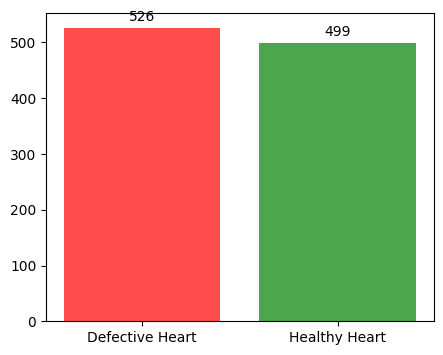

In [6]:
fig, ax = plt.subplots(figsize=(5,4))
bars = ax.bar(labels, values,color=['red','green'],alpha=0.7)
ax.bar_label(bars, padding=3)
plt.show()

**Splitting Data into Feature and Target variables**

In [7]:
X=data.drop(columns=['target'])
Y=data['target']

In [8]:
X.shape

(1025, 13)

In [9]:
Y.shape

(1025,)

**Splitting Data into Training and Testing sets**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

**Buliding Models**

In [11]:
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [12]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [13]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [14]:
def get_roc_curve(model,X_test,y_test):
  model_probs=model.predict_proba(X_test)[:,1]
  fpr,tpr,_=roc_curve(y_test,model_probs)
  auc_score=roc_auc_score(y_test,model_probs)
  return (fpr,tpr,auc_score)

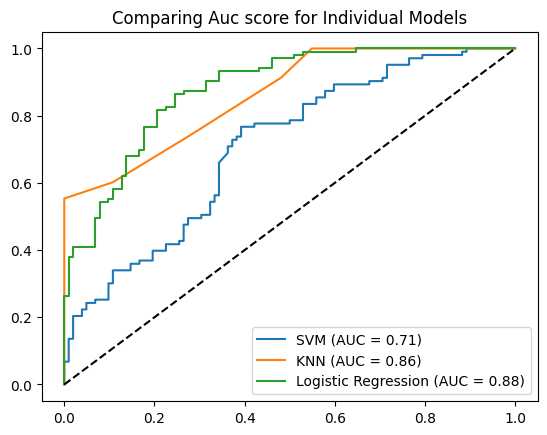

In [15]:
models={"SVM":svm,"KNN":knn,"Logistic Regression":lr}
for i in models:
  fpr,tpr,auc_score=get_roc_curve(models[i],X_test,y_test);
  plt.plot(fpr,tpr,label=f"{i} (AUC = {round(auc_score,2)})")
plt.title("Comparing Auc score for Individual Models")
plt.plot([0, 1], [0, 1],'--',color='black')
plt.legend()
plt.show()

In [16]:
voting_clf_soft = VotingClassifier(
    estimators=[
        ('knn', knn),
        ('svm', svm),
        ('lr', lr)
    ],
    voting='soft'
)
voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('lr', LogisticRegression(random_state=42))],
                 voting='soft')

In [17]:
voting_clf_hard = VotingClassifier(
    estimators=[
        ('knn', knn),
        ('svm', svm),
        ('lr', lr)
    ],
    voting='hard'
)
voting_clf_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('lr', LogisticRegression(random_state=42))])

**Comparing Voting Model Performances**

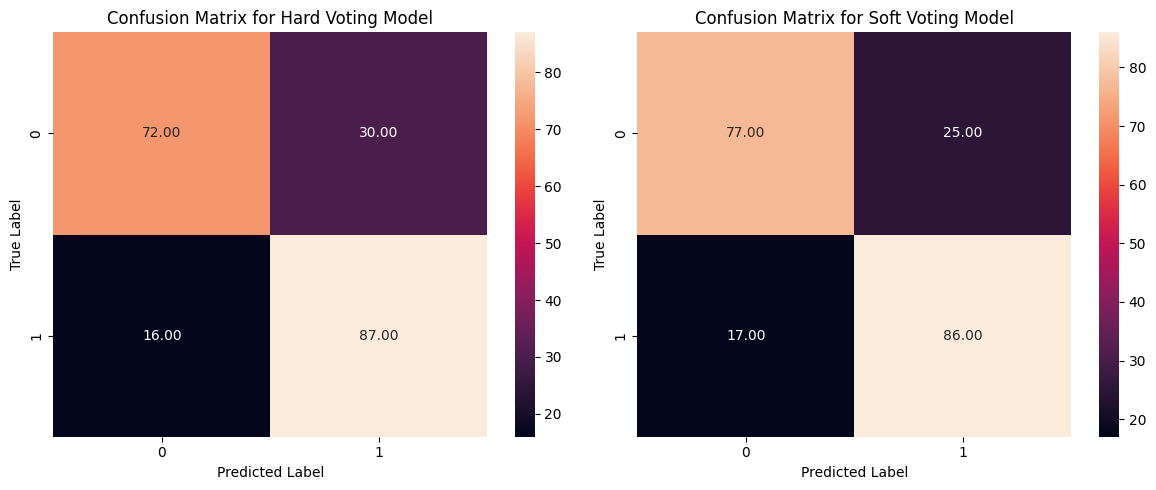

In [18]:
def get_confusion_matrix(model,X_test,y_test):
  y_pred = model.predict(X_test)
  cm=confusion_matrix(y_test, y_pred)
  return cm;
voting_models={"Hard Voting":voting_clf_hard,"Soft Voting":voting_clf_soft}
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (name, model) in zip(axes, voting_models.items()):
  cm=get_confusion_matrix(model,X_test,y_test)
  sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=[0,1], yticklabels=[0,1], ax=ax)
  ax.set_title(f"Confusion Matrix for {name} Model")
  ax.set_xlabel('Predicted Label')
  ax.set_ylabel('True Label')
plt.tight_layout()
plt.show()

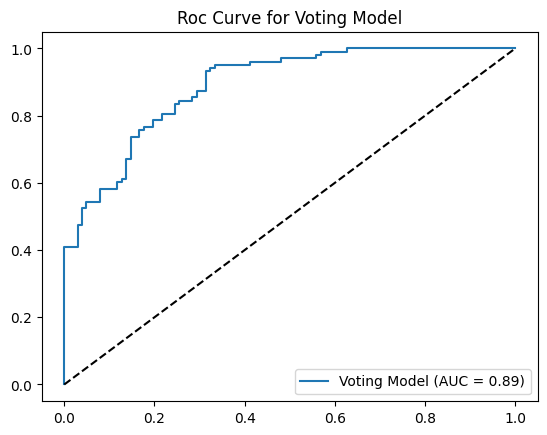

In [19]:
fpr,tpr,auc_score=get_roc_curve(voting_clf_soft,X_test,y_test);
plt.plot(fpr,tpr,label=f"Voting Model (AUC = {round(auc_score,2)})")
plt.plot([0, 1], [0, 1],'--',color='black')
plt.title("Roc Curve for Voting Model")
plt.legend()
plt.show()